In [1]:
#Data Manipulation library
import numpy as np
import pandas as pd

#Plotting library
import seaborn as sns
import matplotlib.pyplot as plt

#Data Processing library
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

#Machine learning Library
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#Deep learning Library
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.models import load_model

#Model evaluation library
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,roc_curve,auc



#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other
import os
from collections import Counter

C:\Users\Vishwanath.RM\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import Data

In [18]:
path=r'C:\Users\Vishwanath.RM\Desktop\Learning\hacathon\Social Financial Lending'
os.chdir(path)
TRAIN=pd.read_csv(r"DATA\application_train.csv")
TEST=pd.read_csv(r"DATA\application_test.csv")
print("TRAIN.shape:",TRAIN.shape)
print("TEST.shape:",TEST.shape)
print("Value Count:",TRAIN.TARGET.value_counts(normalize=True))

TRAIN.shape: (257512, 122)
TEST.shape: (49999, 121)
Value Count: 0    0.919231
1    0.080769
Name: TARGET, dtype: float64


## EDA

In [19]:
#categorical and Numerical Values
columns=list(TRAIN.columns)
numeric=list(TRAIN._get_numeric_data().columns)
categorical=list(set(TRAIN.columns)-set(numeric))
print("DATA type count",TRAIN.get_dtype_counts())

DATA type count float64    64
int64      42
object     16
dtype: int64


#### Categorical Values

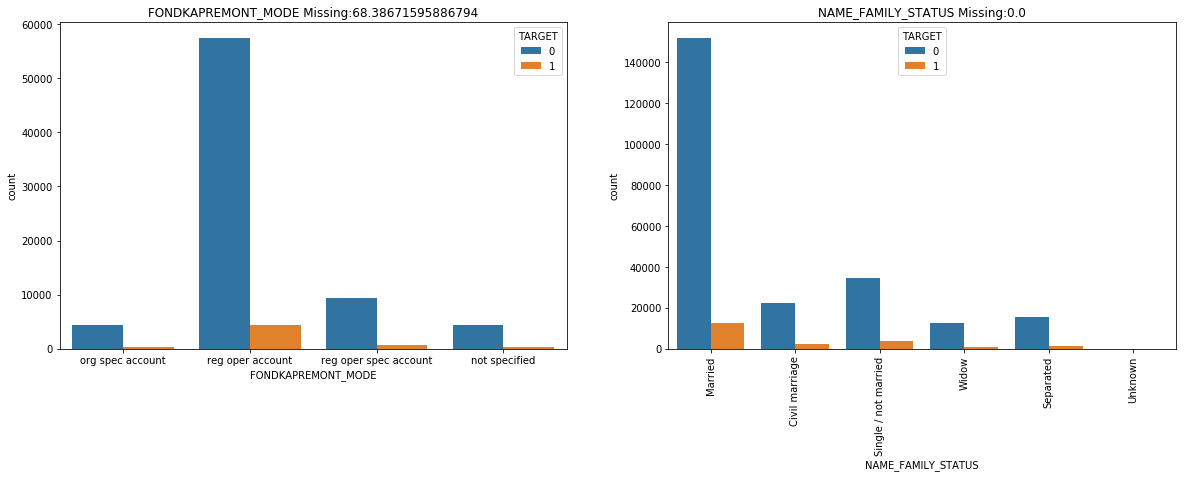

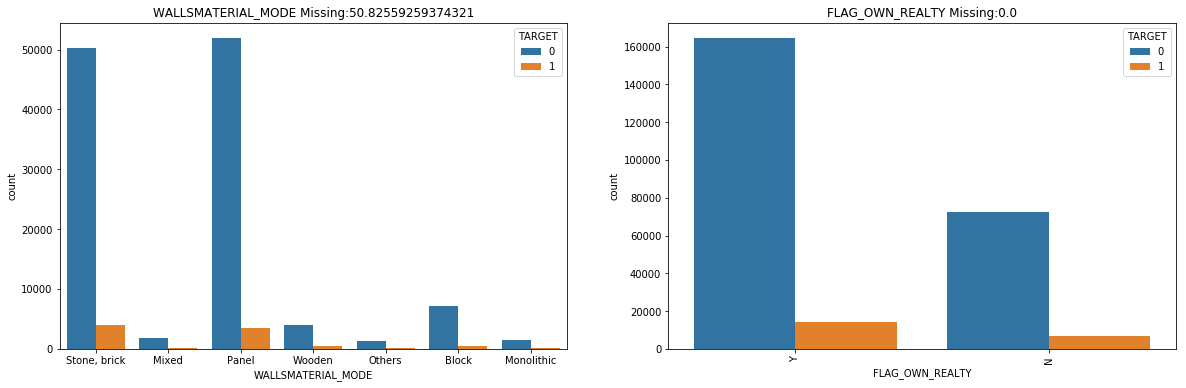

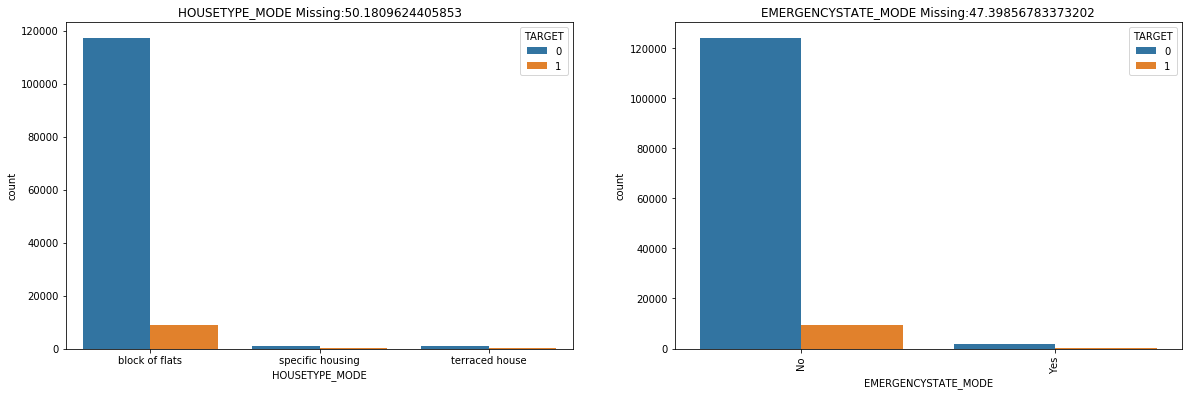

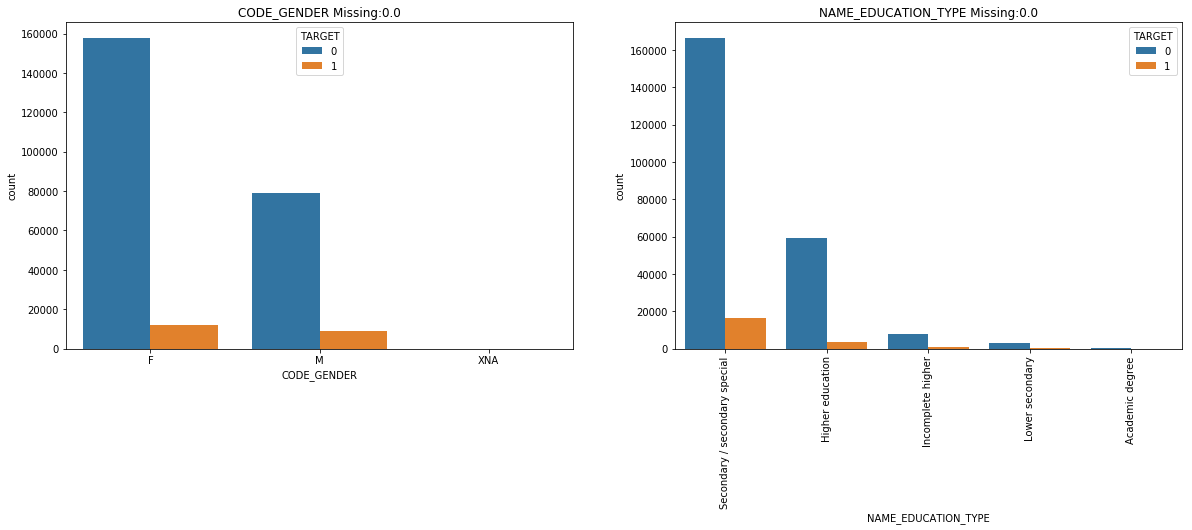

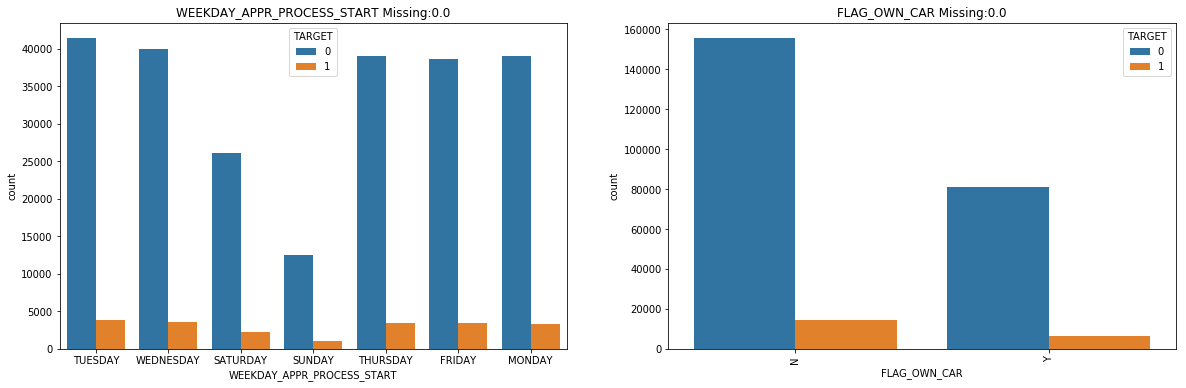

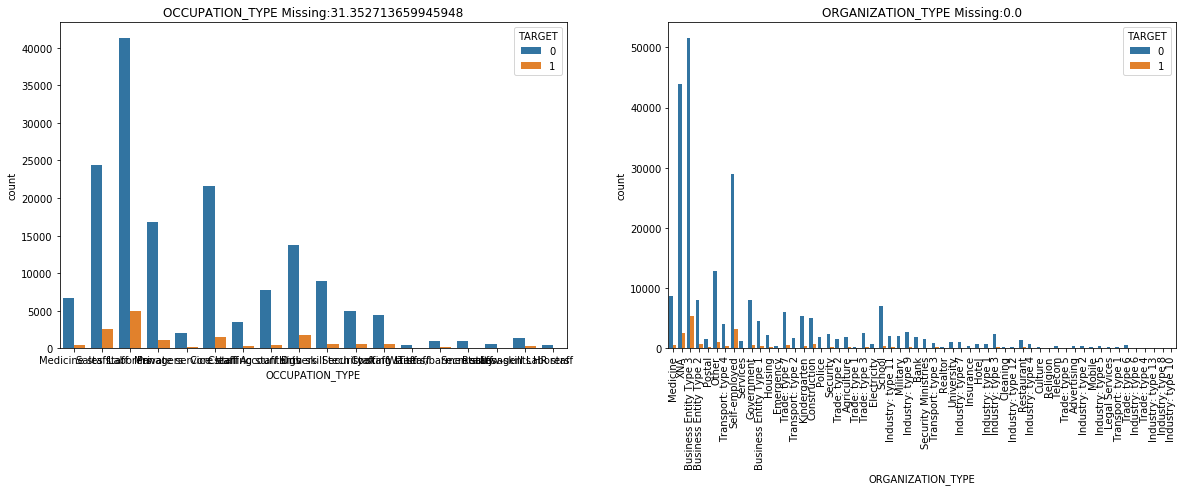

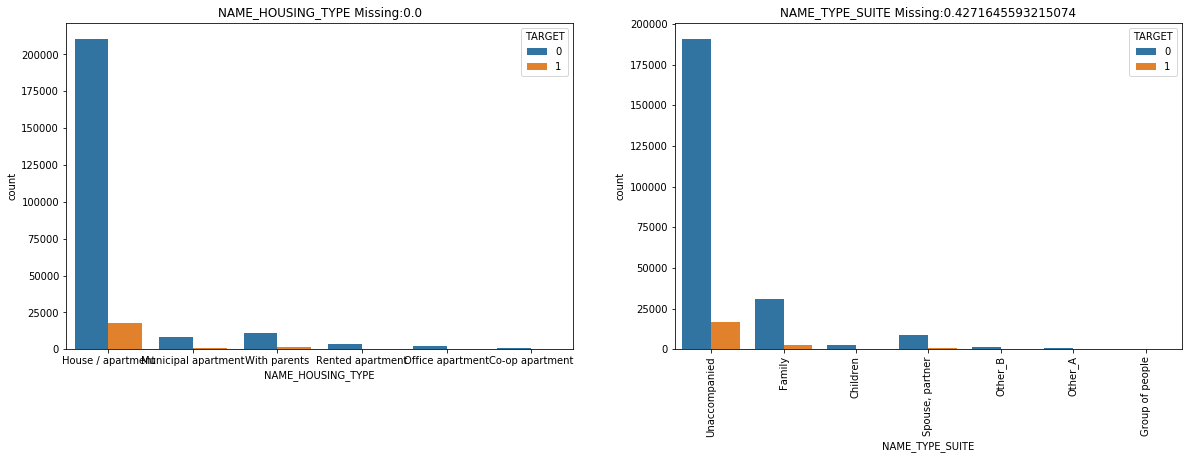

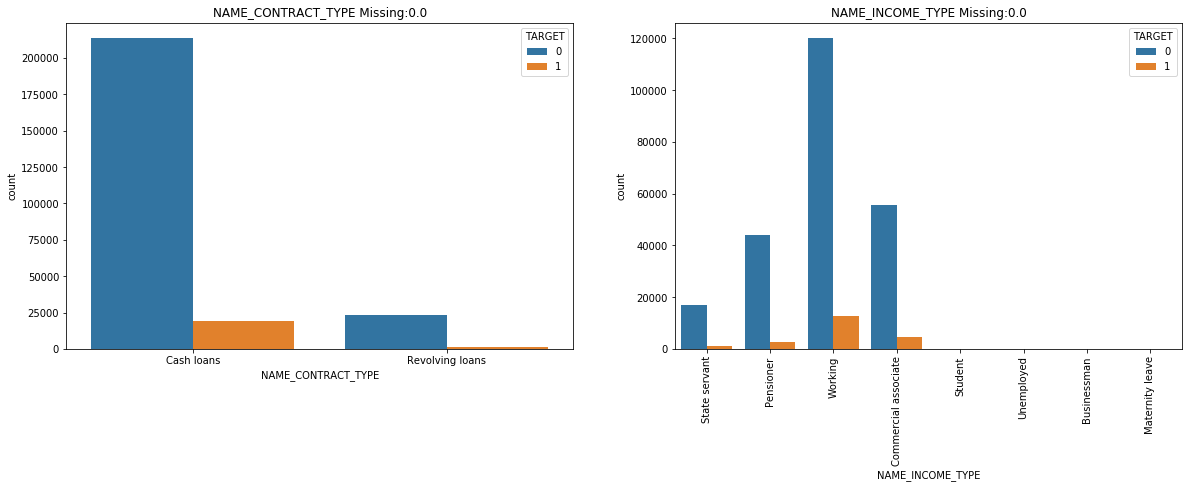

In [20]:
for i in range(0,len(categorical),2):
    var=categorical[i]
    fig ,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,6))
    sns.countplot(x=var, data=TRAIN,hue='TARGET',ax=ax1)
    plt.xticks(rotation=90)
    per=(TRAIN[var].isnull().sum()/(len(TRAIN)))*100
    #print("Missing Count: {} Missing_Per:{}".format(TRAIN[var].isnull().sum(),per))
    #print("Cat Counts",len(TRAIN[var].value_counts()))
    DATA=pd.DataFrame(TRAIN[var].value_counts()/len(TRAIN)).reset_index()
    DATA.columns=[var,'PER_COUNT']
    DATA['COUNT']=DATA[var].map(TRAIN[var].value_counts().to_dict())
    ax1.set_title(var+" Missing:"+str(per))
        
    var=categorical[i+1]
    ax2 = sns.countplot(x=var, data=TRAIN,hue='TARGET',ax=ax2)
    plt.xticks(rotation=90)
    per=(TRAIN[var].isnull().sum()/(len(TRAIN)))*100
    #print("Missing Count: {} Missing_Per:{}".format(TRAIN[var].isnull().sum(),per))
    #print("Cat Counts",len(TRAIN[var].value_counts()))
    DATA=pd.DataFrame(TRAIN[var].value_counts()/len(TRAIN)).reset_index()
    DATA.columns=[var,'PER_COUNT']
    DATA['COUNT']=DATA[var].map(TRAIN[var].value_counts().to_dict())
    ax2.set_title(var+" Missing:"+str(per))
    plt.show()

#### Numerical Values

In [6]:
# Age on Target variable
#plt.figure(figsize=(10,5))
#mask=(TRAIN['TARGET']==0)
#plt.plot(TRAIN.loc[mask,'AGE'],lw=0,marker='o')
#plt.plot(TRAIN.loc[~mask,'AGE'],lw=0,marker='o',color='r')

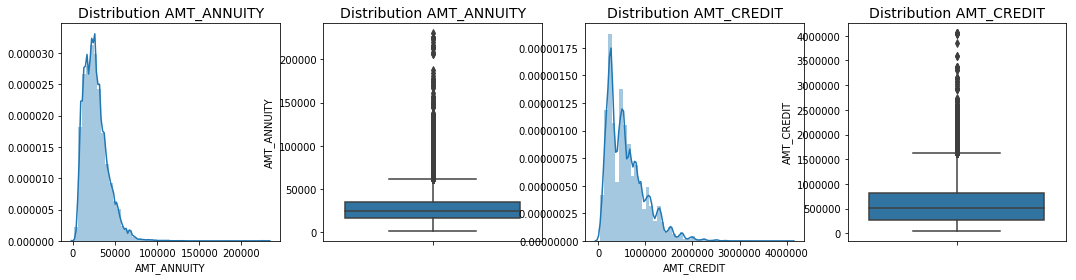

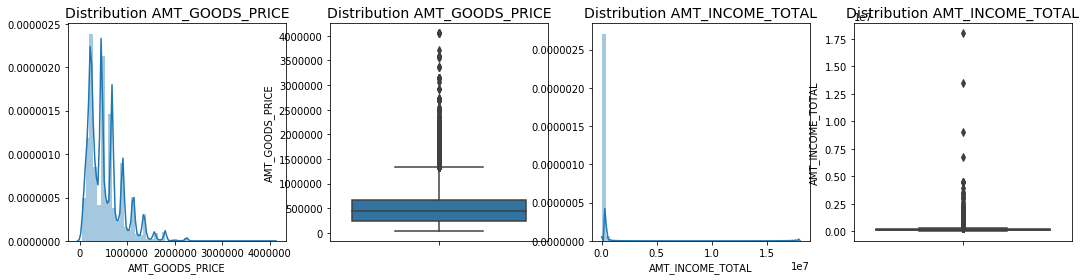

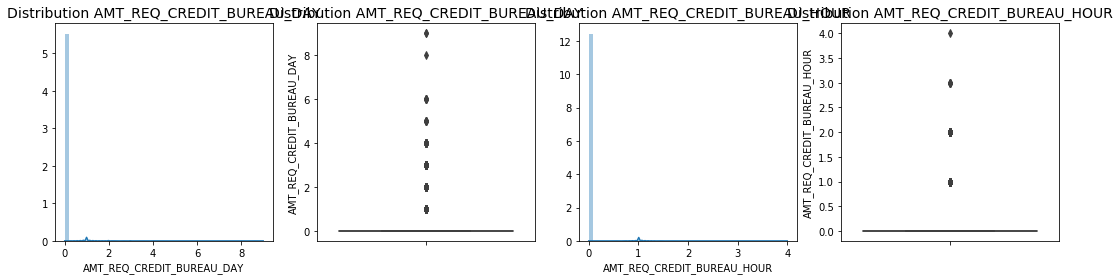

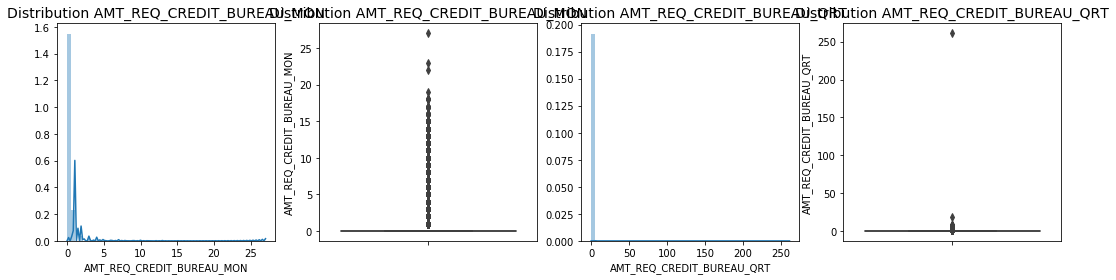

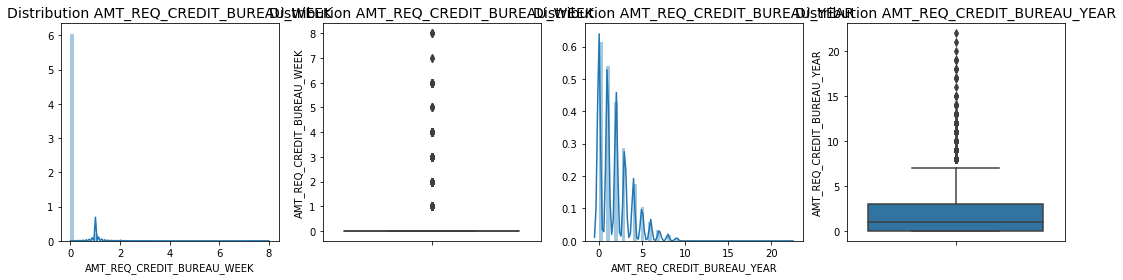

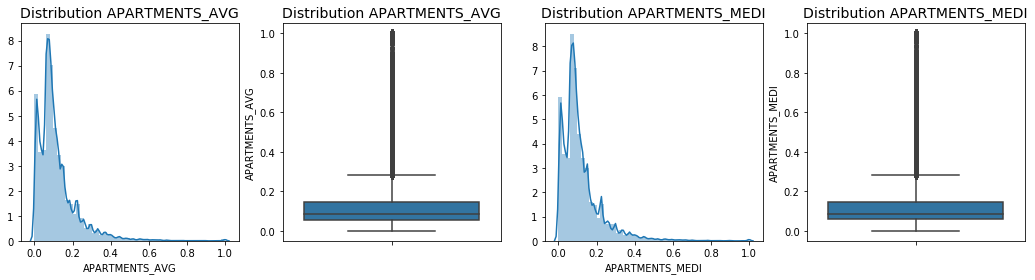

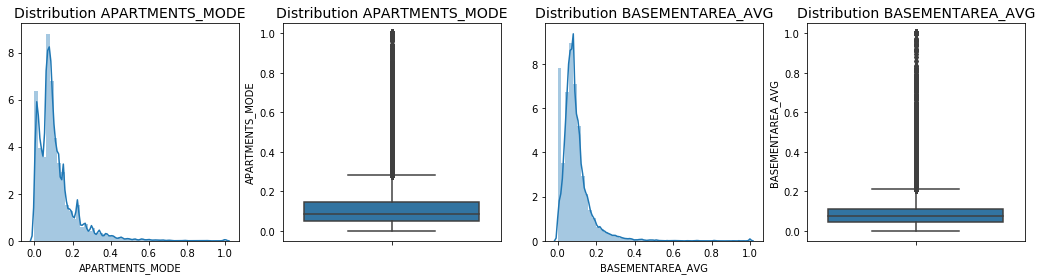

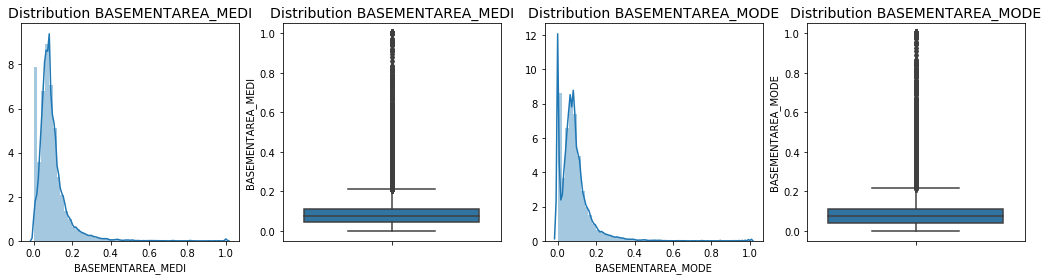

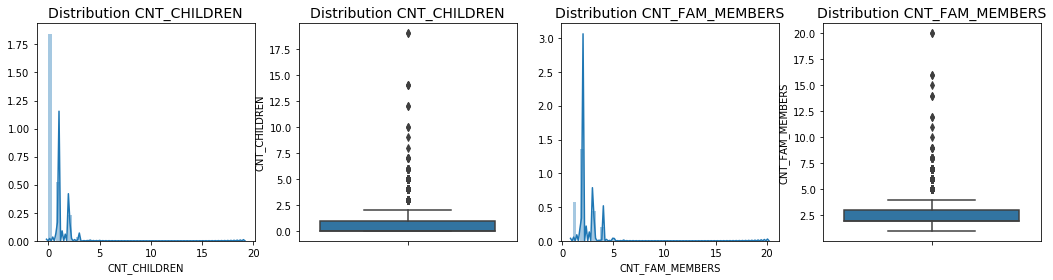

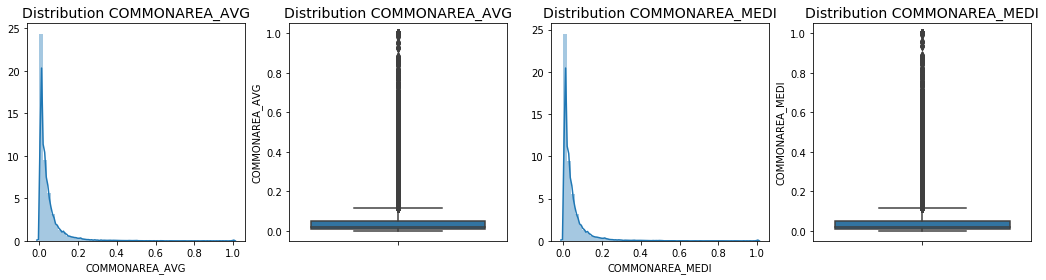

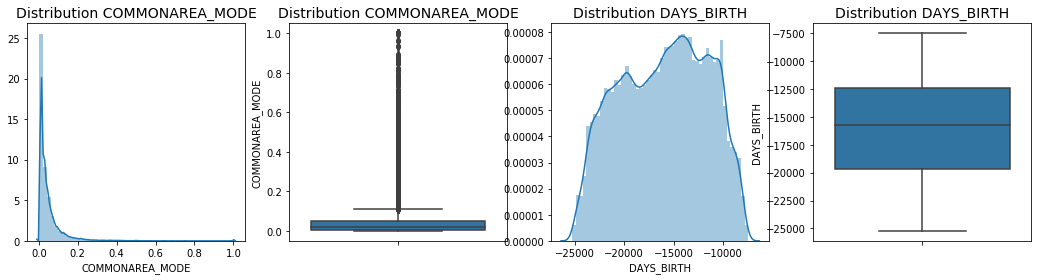

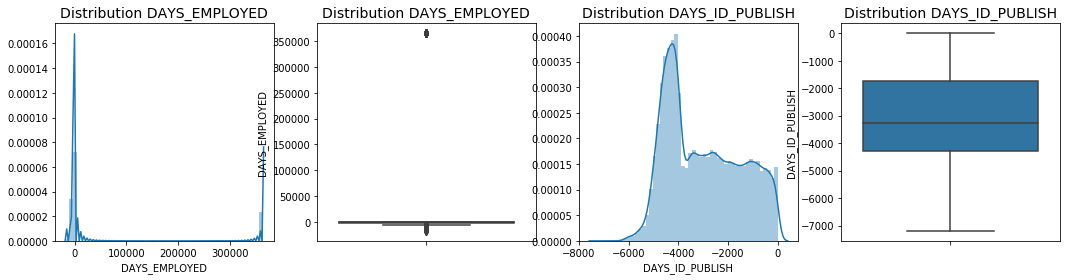

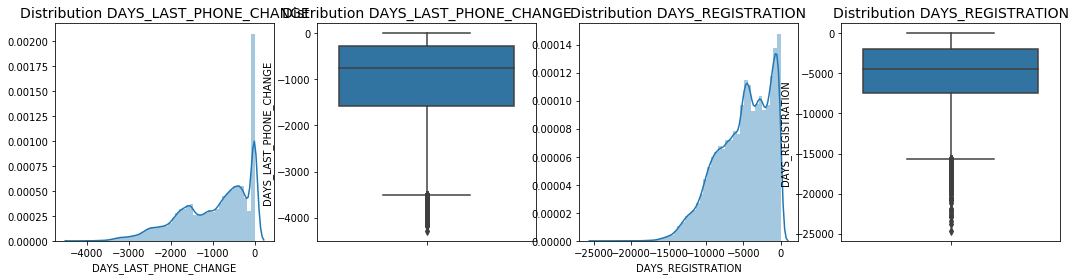

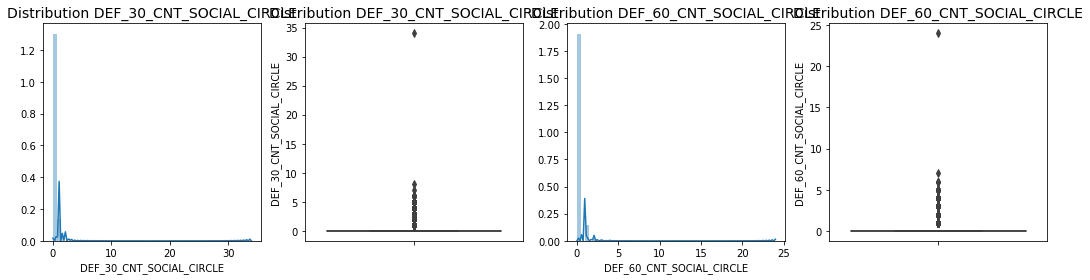

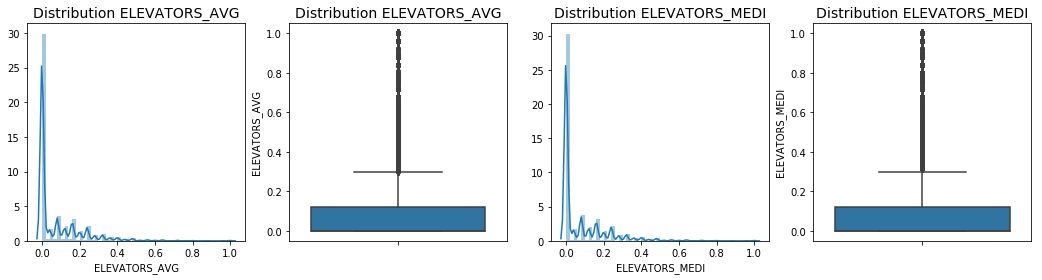

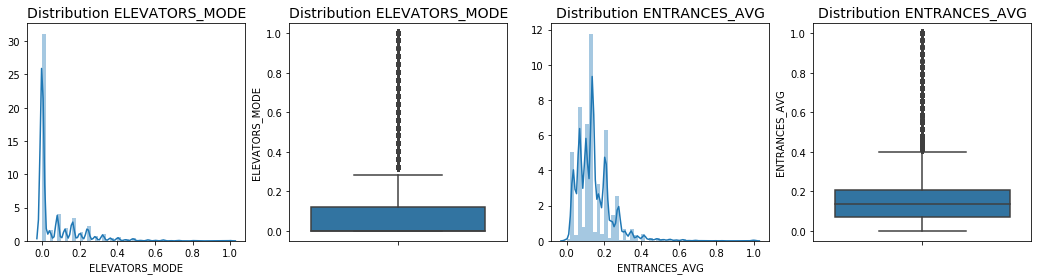

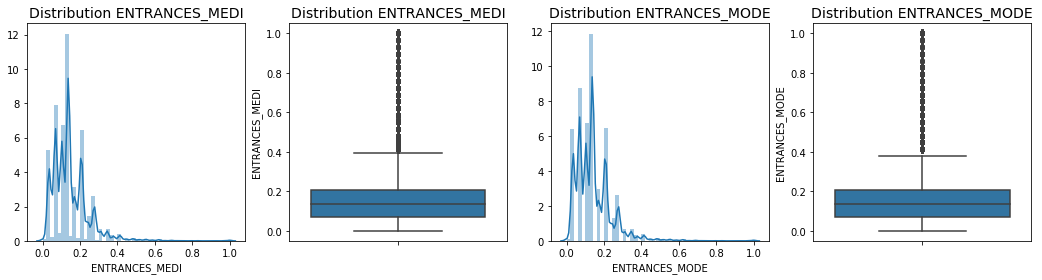

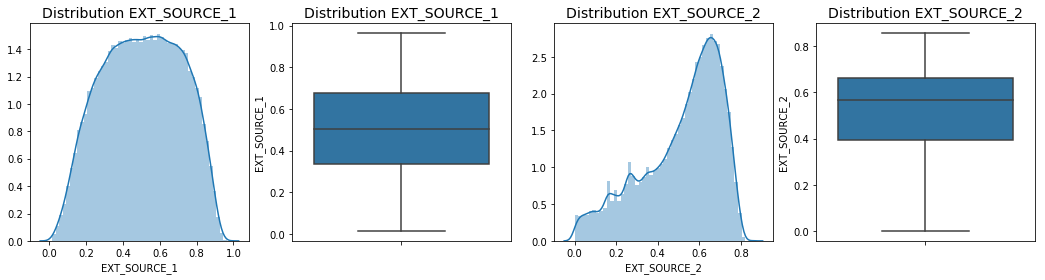

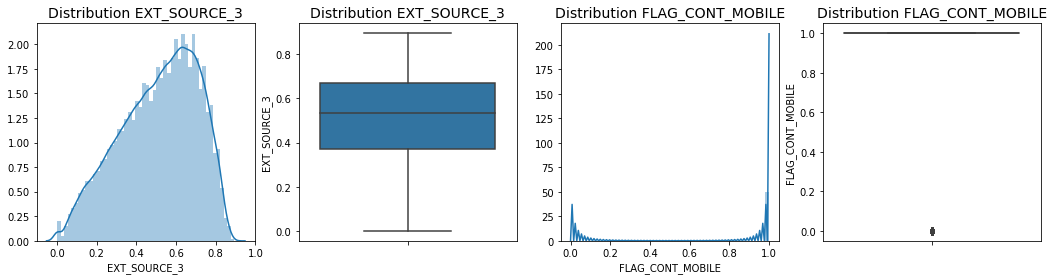

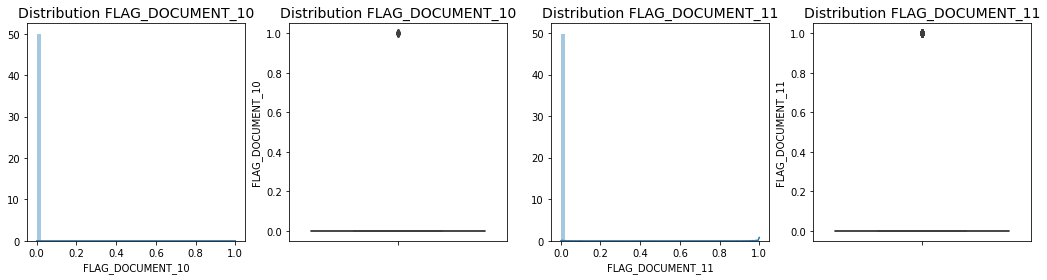

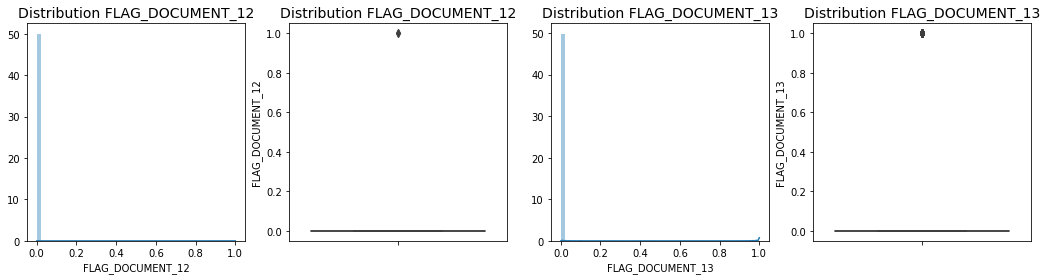

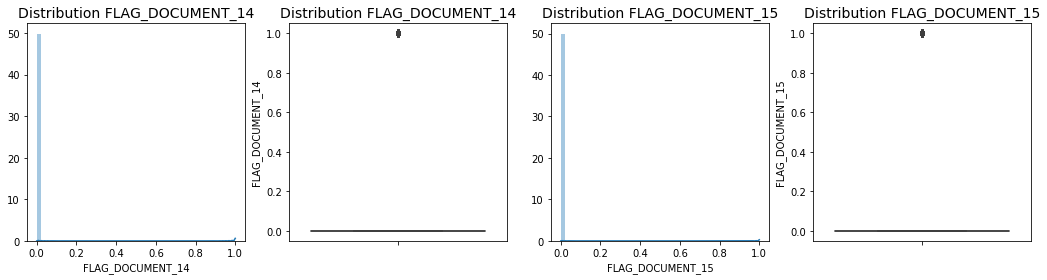

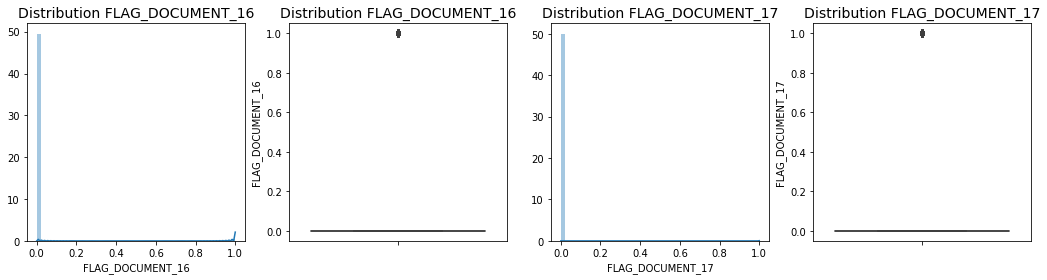

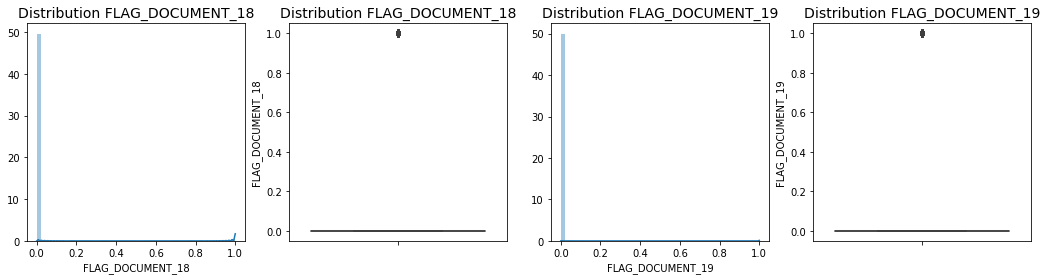

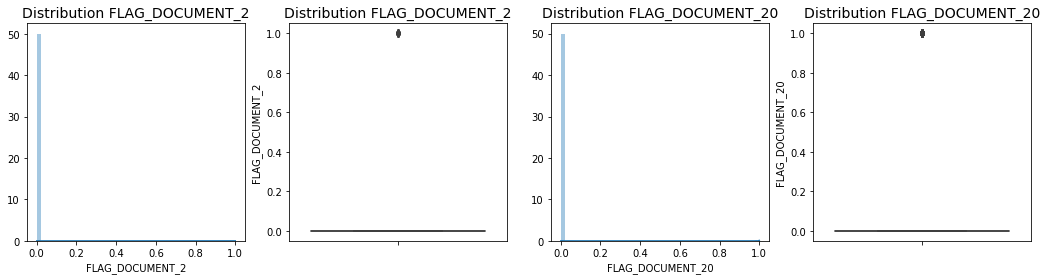

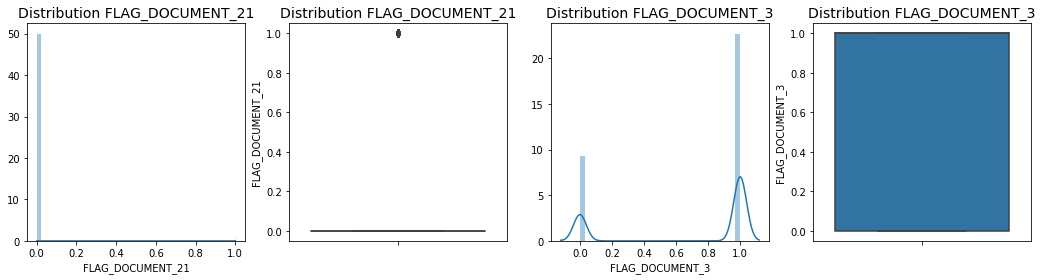

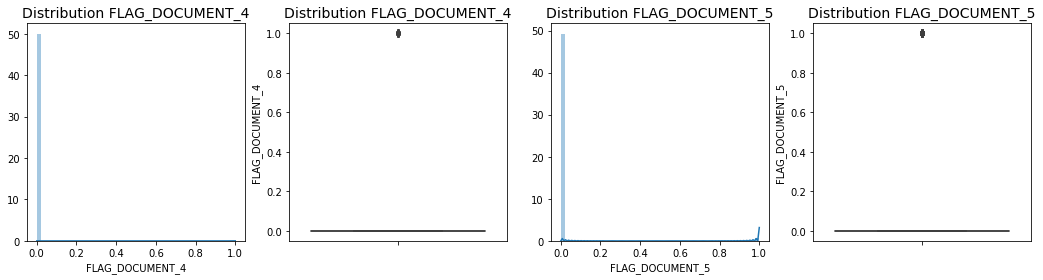

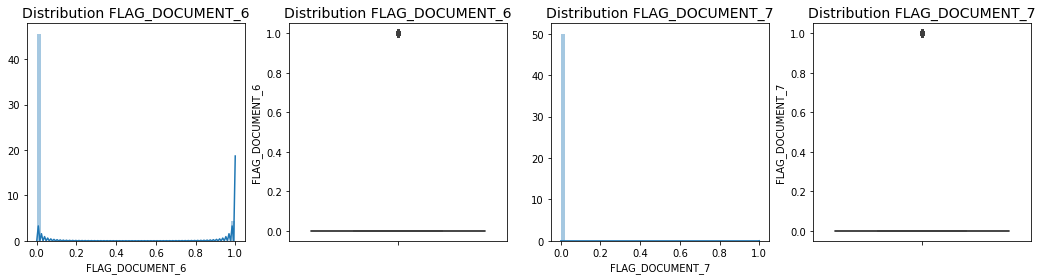

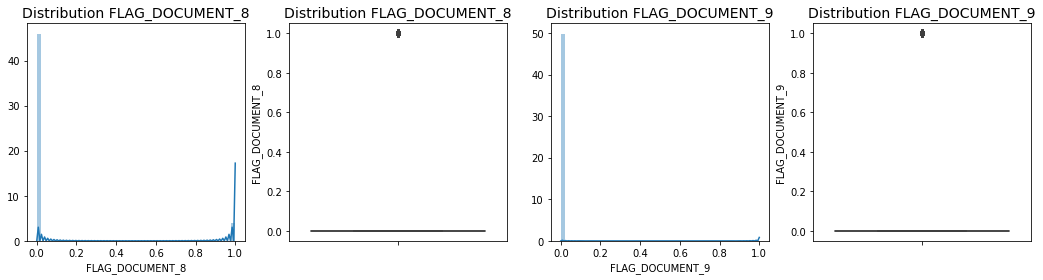

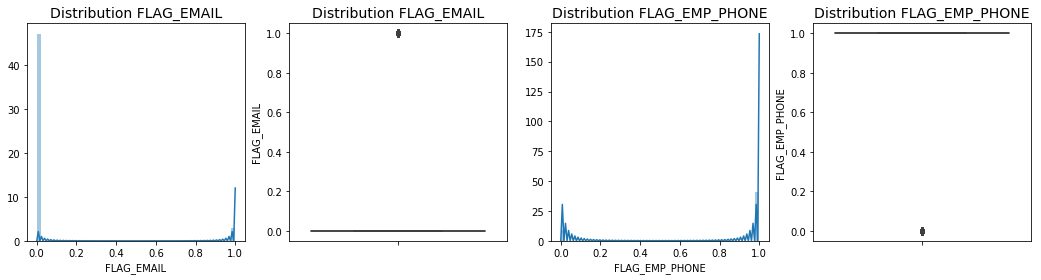

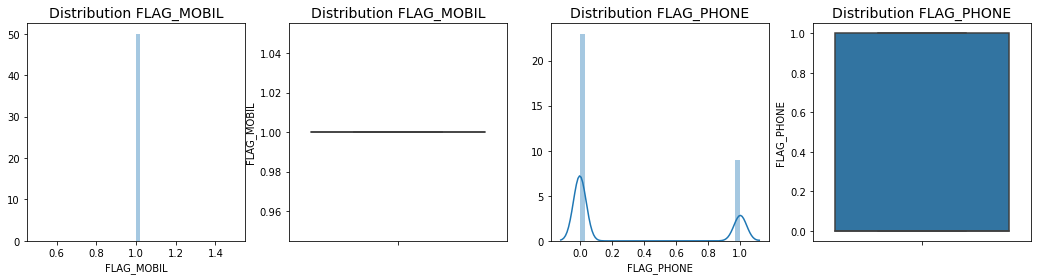

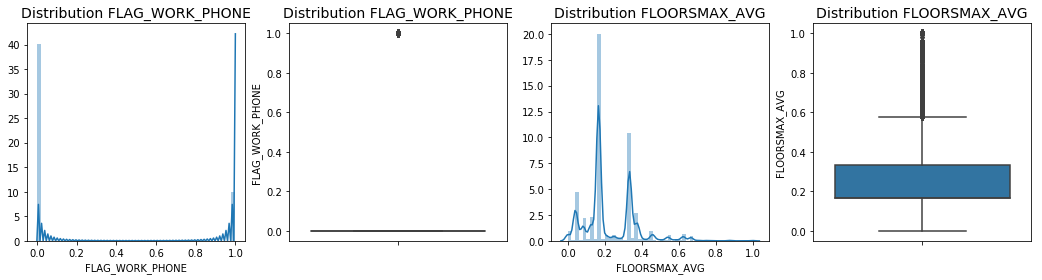

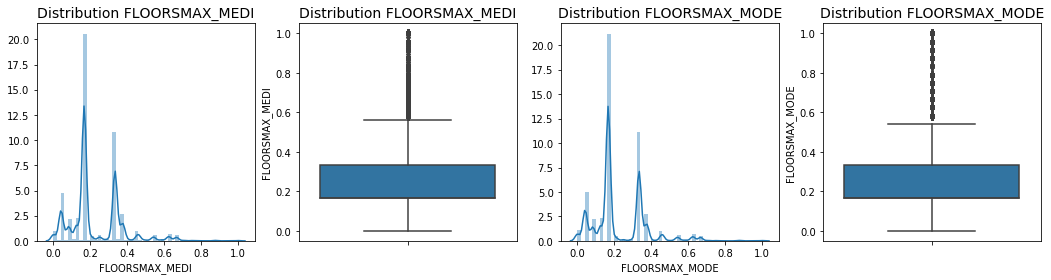

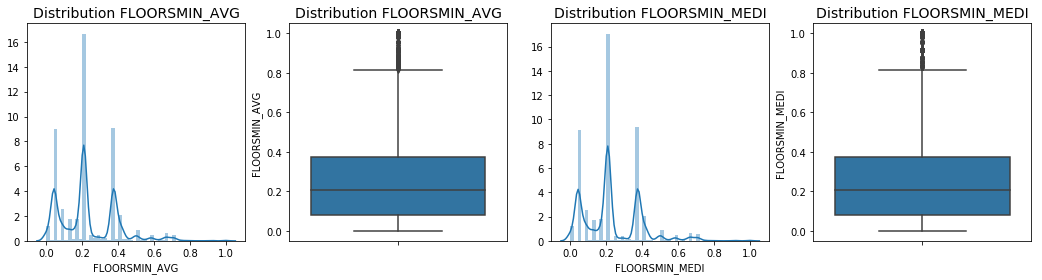

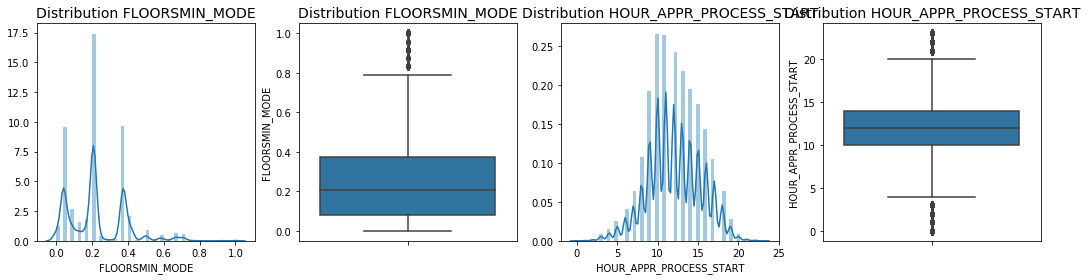

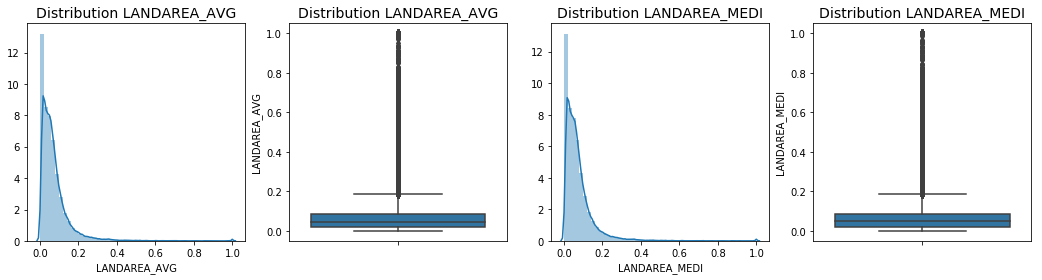

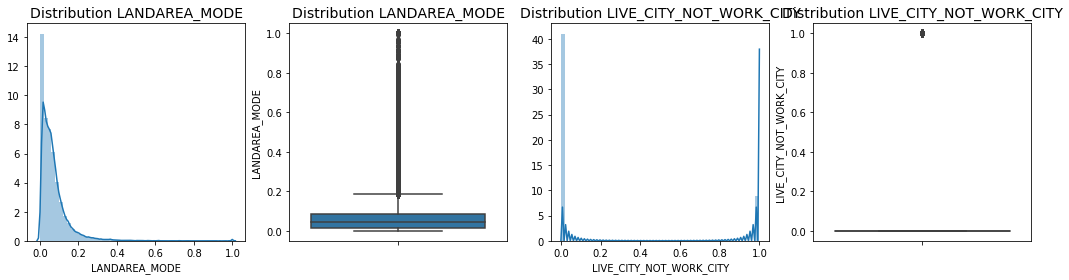

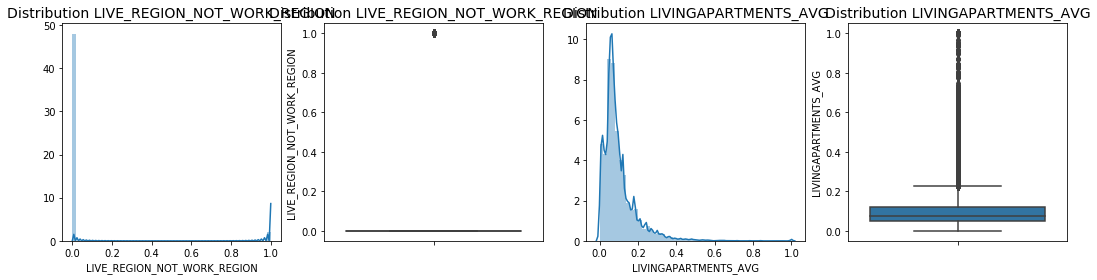

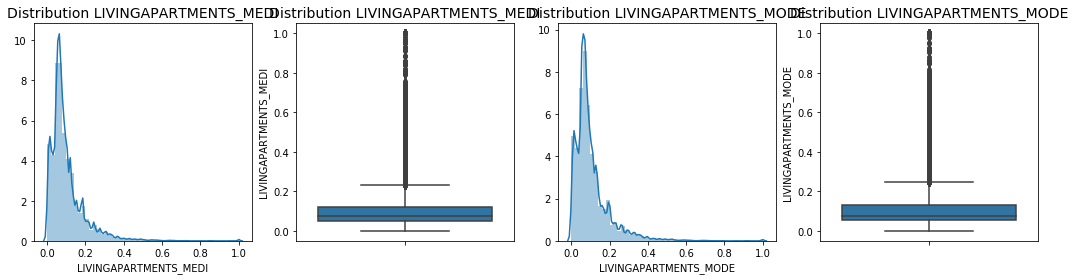

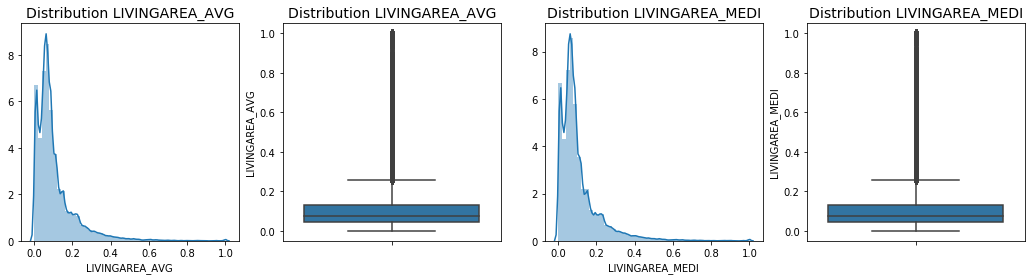

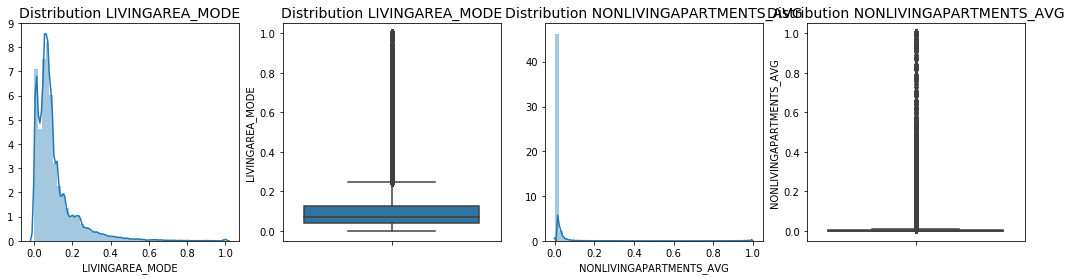

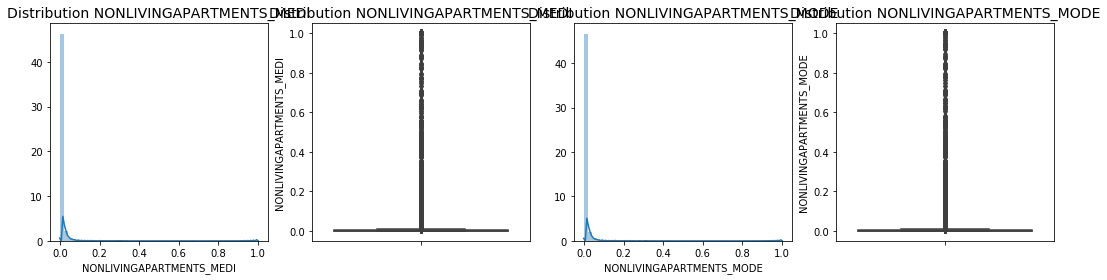

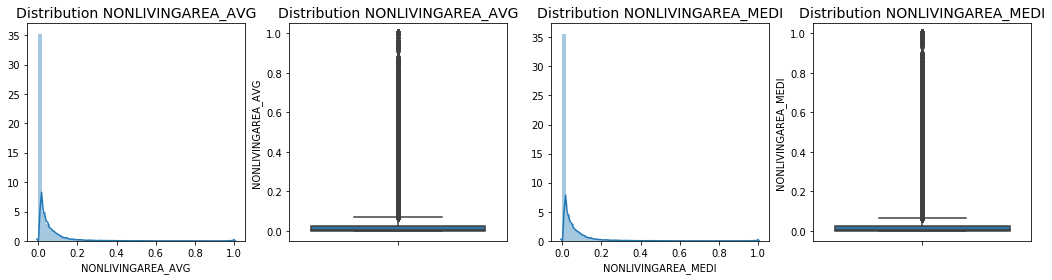

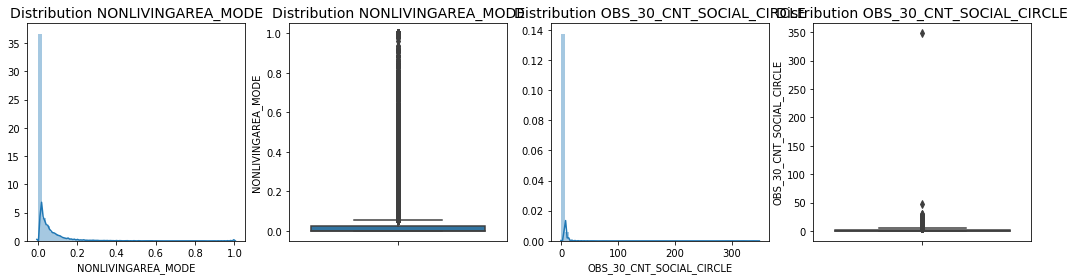

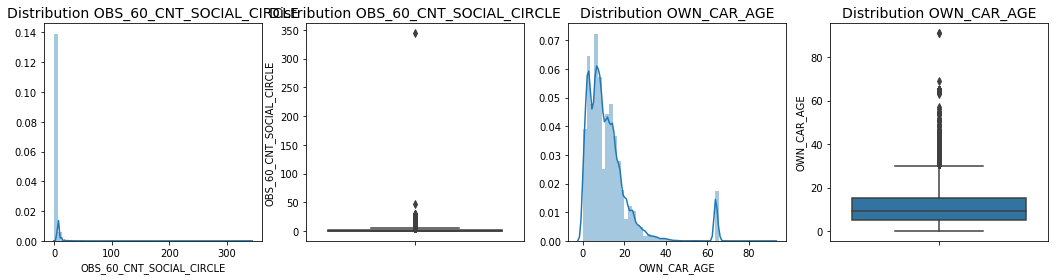

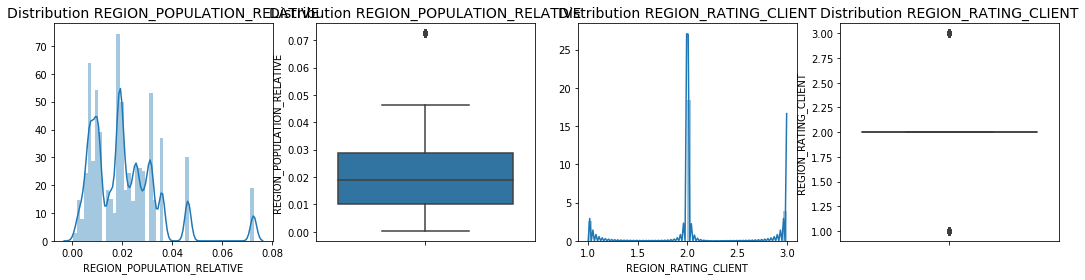

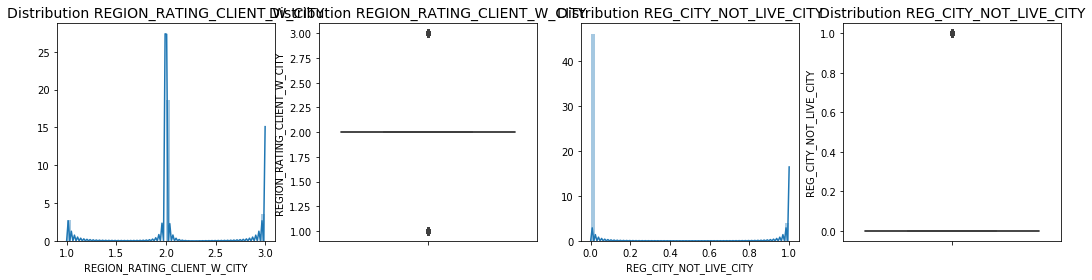

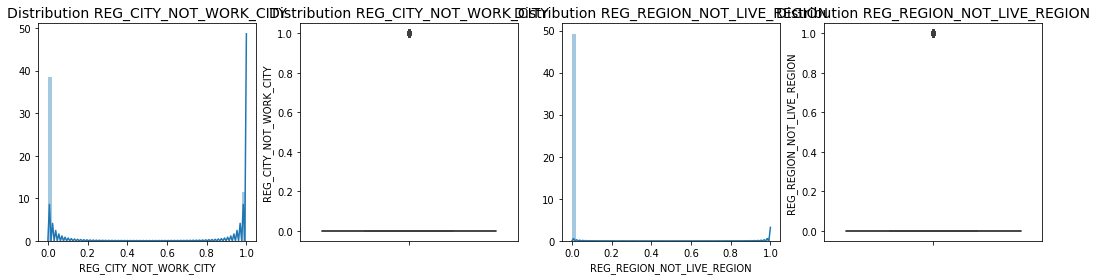

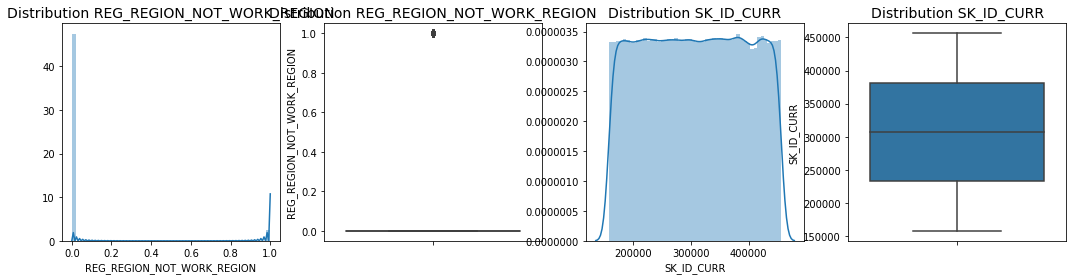

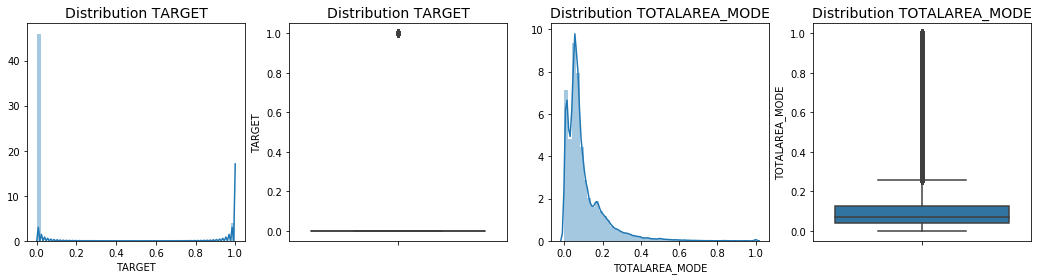

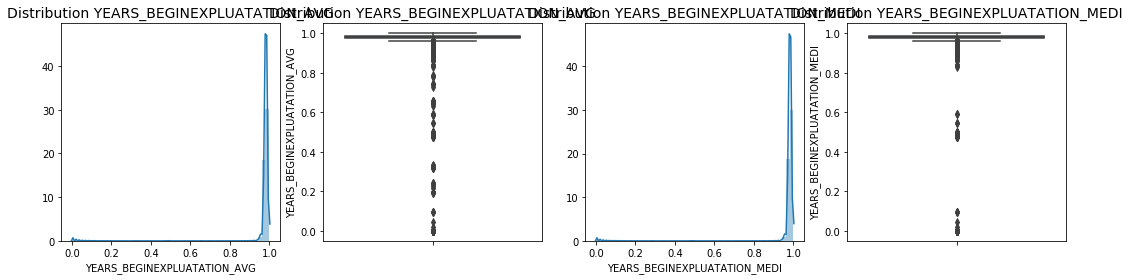

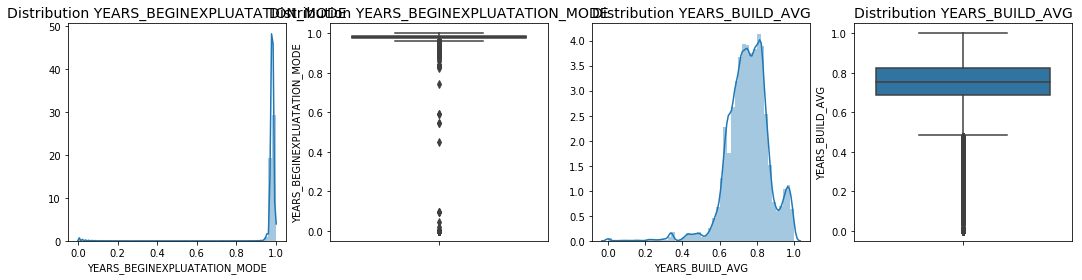

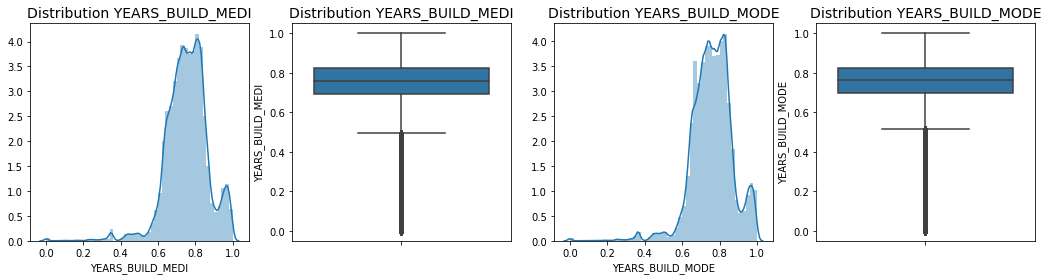

In [27]:
## Distribution of each plots
numeric=sorted(numeric)
for i in range(0,len(numeric),2):
    try:
        col=numeric[i]
        #Distribution of charges over male and female
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
        sns.distplot(TRAIN[col].dropna(),ax=ax1)
        sns.boxplot(x=TRAIN[col].dropna(),ax=ax2,orient='v')
        ax1.set_title('Distribution {}'.format(col), fontsize=14)
        ax2.set_title('Distribution {}'.format(col), fontsize=14)

        col=numeric[i+1]
        sns.distplot(TRAIN[col].dropna(),ax=ax3)
        sns.boxplot(x=TRAIN[col].dropna(),ax=ax4,orient='v')
        ax3.set_title('Distribution {}'.format(col), fontsize=14)
        ax4.set_title('Distribution {}'.format(col), fontsize=14)
    except Exception as e:
        print(e)
        pass

## Preprocessing

In [28]:
##Combining Train and test Data
TEST['TYPE']='TEST'
TEST['TARGET']=0  #assume
TRAIN['TYPE']='TRAIN'
FULLDATA=TRAIN[TRAIN.columns].append(TEST[TRAIN.columns])

#Numerical
FULLDATA_NUM=FULLDATA[numeric]

#Categorical
FULLDATA_CAT=FULLDATA[categorical]

In [29]:
FULLDATA.shape

(307511, 123)

#### Treating The Missing Values

In [30]:
##Remove categorical columns with more than 45% of missing value
size=len(FULLDATA_CAT)
cat_missing_more_than_45=[]
for col in categorical:
    if FULLDATA_CAT[col].isnull().sum()/size>0.45:
        categorical.remove(col)
        cat_missing_more_than_45.append(col)

##Remove numerical columns with more than 45% of missing value
size=len(FULLDATA_NUM)
num_missing_more_than_45=[]
for col in numeric:
    if FULLDATA_NUM[col].isnull().sum()/size>0.45:
        numeric.remove(col)
        num_missing_more_than_45.append(col)
        
#selected columns
columns=numeric[:]
columns.extend(categorical)
columns.append("TYPE")

## Fill the missing value
FULLDATA=FULLDATA[columns]
for col in columns:
    if col in numeric:
        FULLDATA[col].fillna(value=FULLDATA[col].mean(),inplace=True)
    else:
        FULLDATA[col].fillna(value=FULLDATA[col].mode().values[0],inplace=True)

In [31]:
categorical

['NAME_FAMILY_STATUS',
 'FLAG_OWN_REALTY',
 'EMERGENCYSTATE_MODE',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_OWN_CAR',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'NAME_HOUSING_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_CONTRACT_TYPE',
 'NAME_INCOME_TYPE']

In [32]:
#values count less then 0.05 should be filled with 'Other' value
p=5/100  
for x in categorical:
    series = pd.value_counts(FULLDATA[x])
    mask = (series/series.sum() * 100)<5
    FULLDATA[x] = np.where(FULLDATA[x].isin(series[mask].index),'Other',FULLDATA[x])

In [ ]:
## To do 
#Standardized

In [33]:
## Convert categorical Variables into numerical
## One hot encoding
FULLDATA=pd.get_dummies(data=FULLDATA,columns=categorical)

In [164]:
##To Do
##VIF,PCA
##Multi collinearity 
#FULLDATA_NUM[numeric].corr()>0.75

In [374]:
#from sklearn.decomposition import PCA
#pca=PCA(n_components=100)
#sum(pca.explained_variance_ratio_)
#PCA_TRAIN=pca.fit_transform(TRAIN[predictors])

## Model Building

In [34]:
TRAIN=FULLDATA[FULLDATA['TYPE']=='TRAIN']
predictors = [x for x in TRAIN.columns if x not in ['SK_ID_CURR', 'TARGET','TYPE']]
TRAIN_X,VAL_X,TRAIN_y,VAL_y = train_test_split(TRAIN[predictors], TRAIN['TARGET'],stratify=TRAIN['TARGET'],test_size=0.25)

In [35]:
##Model 1
xgb1 = XGBClassifier()
xgb1.fit(TRAIN_X, TRAIN_y)
prediction=xgb1.predict(VAL_X)
f1_score(VAL_y,prediction)

0.009160305343511452

In [36]:
##Model 2
xgb2 = XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic',scale_pos_weight=1,seed=27)
xgb2.fit(TRAIN_X, TRAIN_y)
prediction=xgb2.predict(VAL_X)
f1_score(VAL_y,prediction)

0.02363977485928705

In [ ]:
##Model 3
## Imbalance Data set
## SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio='minority',random_state=42,)
X_smote_res, y_smote_res = sm.fit_sample(TRAIN[predictors], TRAIN['TARGET'])
from collections import Counter
print('Resampled dataset shape SMOTE {}'.format(Counter(y_smote_res)))

xgb3 = XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic',scale_pos_weight=1,seed=27)
xgb3.fit(X_smote_res, y_smote_res)
prediction=xgb3.predict(np.array(VAL_X))
#f1_score(VAL_y,prediction)

In [9]:
##Feature Importance
FEATURE_IMP=pd.DataFrame()
FEATURE_IMP['Name']=list(TRAIN_X.columns)
FEATURE_IMP['Score']=list(xgb2.feature_importances_)
FEATURE_IMP.sort_values(by=['Score'],ascending=False)

NameError: name 'TRAIN_X' is not defined

In [ ]:
#false_pos_rate, true_pos_rate, thresholds=roc_curve(VAL_y,xgb2.predict_proba(VAL_X)[:,0])
#roc_auc = auc(false_pos_rate, true_pos_rate,)
#plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
#plt.plot([0,1],[0,1], linewidth=5)

#plt.xlim([-0.01, 1])
#plt.ylim([0, 1.01])
#plt.legend(loc='lower right')
#plt.title('Receiver operating characteristic curve (ROC)')
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()